<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#итоговый-вывод" data-toc-modified-id="итоговый-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>итоговый вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.index.is_monotonic

True

In [6]:
df.isna().sum()

num_orders    0
dtype: int64

In [7]:
df = df.resample('1H').sum()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Данные загружены, дпты выступают в качестве индексов, пропусков не обнаружено, дубликаты могут быть, тк данные числовые. Проведено ресемплирование по одному часу

## Анализ

In [9]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


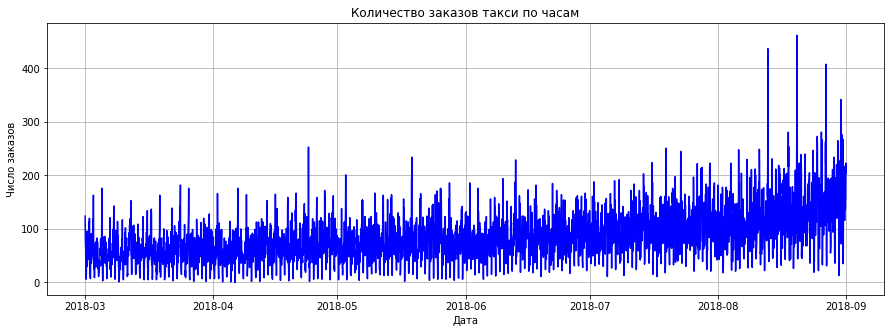

In [10]:
plt.figure(figsize=(15, 5))
plt.plot(df['num_orders'], color='blue')
plt.title('Количество заказов такси по часам')
plt.xlabel('Дата')
plt.ylabel('Число заказов')
plt.grid(True)

Возможен восходящий тренд, что указывает на рост заказов. Видны суточные колебания.

<AxesSubplot:title={'center':'остатки'}, xlabel='datetime'>

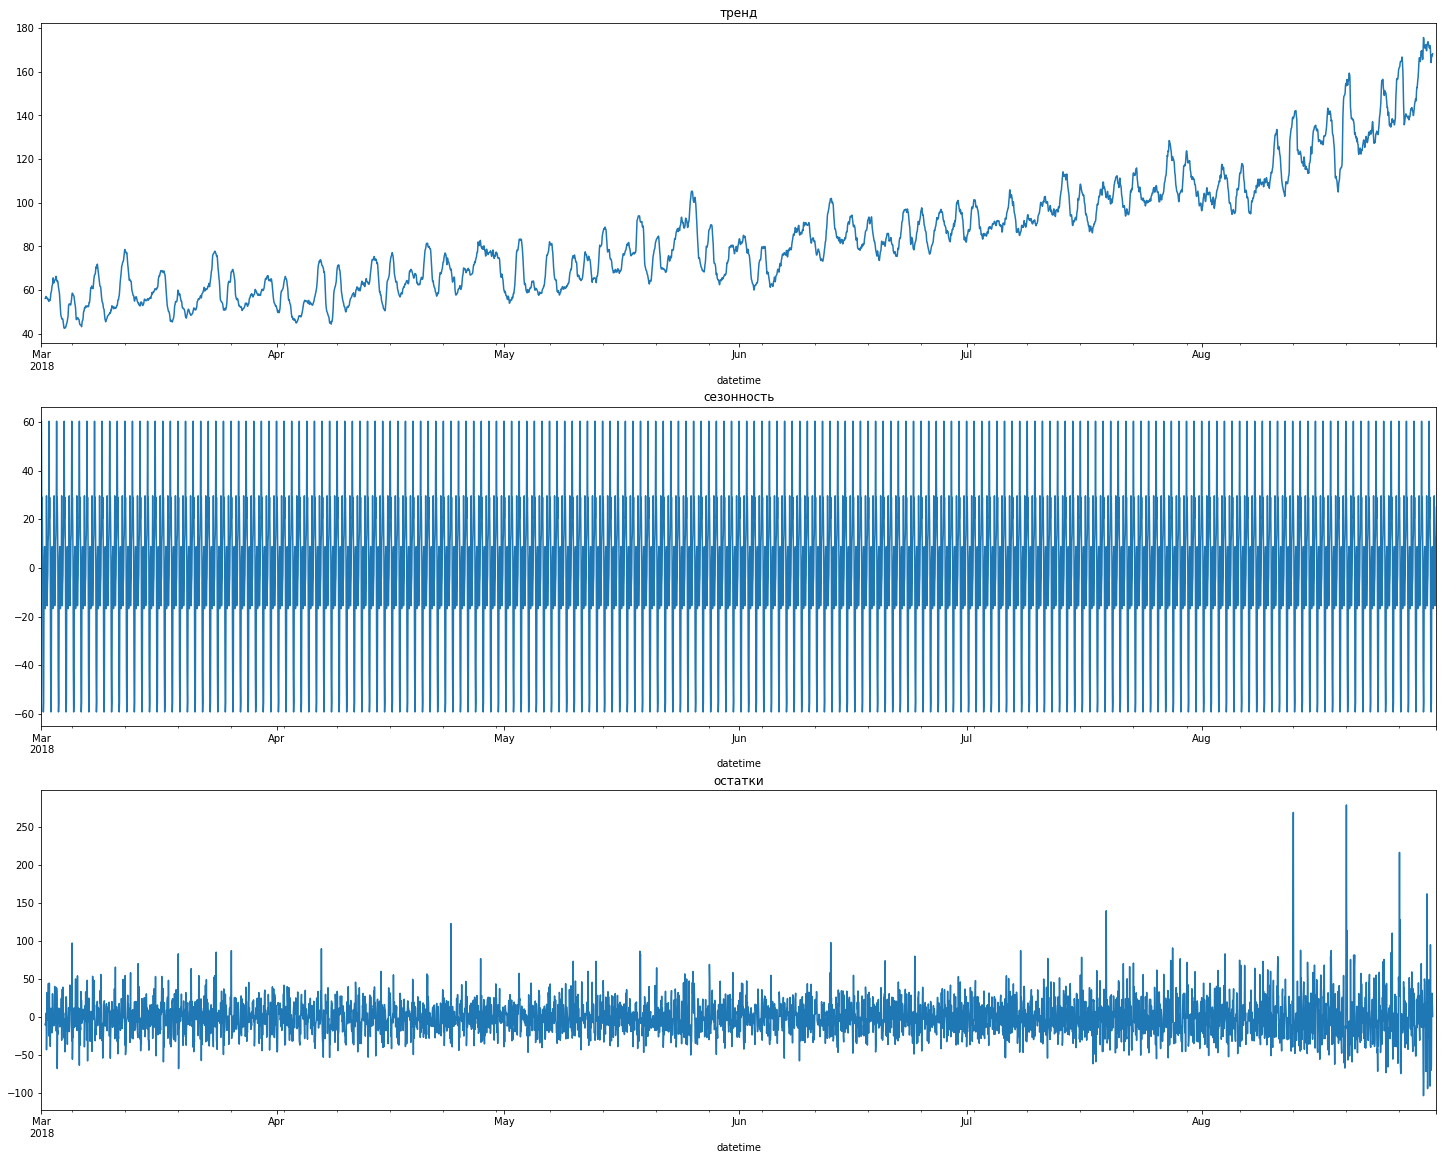

In [11]:
decomposed = seasonal_decompose(df["num_orders"])
fig,ax = plt.subplots(3,1,figsize = (25,20))

decomposed.trend.plot(ax=ax[0],title = 'тренд')
decomposed.seasonal.plot(ax=ax[1],title = 'сезонность')
decomposed.resid.plot(ax=ax[2],title = 'остатки')

Верхний график, отображающий тренд, показывает постепенный рост количества заказов со временем, что указывает на восходящий тренд, возможно, связанный с увеличением популярности сервиса. Средний график, представляющий сезонность, демонстрирует регулярные суточные колебания с периодом около 24 часов, что типично для заказов такси с пиками в утренние и вечерние часы, хотя плотность данных делает его менее читаемым и требует ограничения выборки для анализа. Нижний график остатков выявляет значительное количество шума и случайных всплесков, что может быть связано с аномалиями или внешними факторами, такими как праздники или мероприятия.

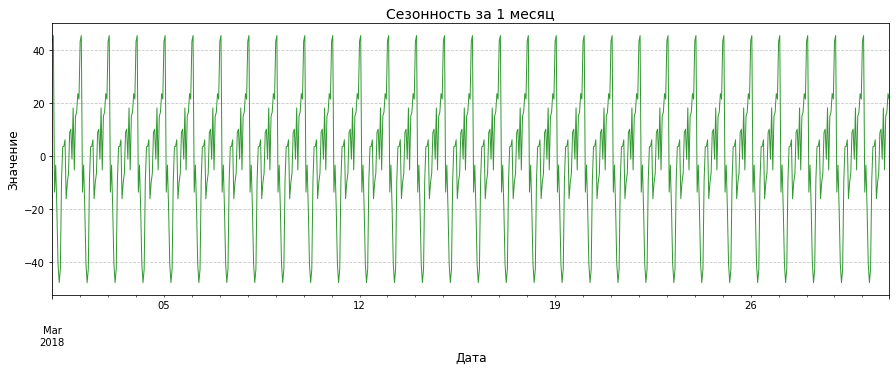

In [12]:
df_month = df['num_orders'][:720]

decomposed_month = seasonal_decompose(df_month)

plt.figure(figsize=(15, 5))
decomposed_month.seasonal.plot(ax=plt.gca(), grid=True, color='green', linewidth=1, alpha=0.8)
plt.title('Сезонность за 1 месяц', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

График демонстрирует регулярные суточные колебания с периодом около 24 часов, что подтверждает наличие четкой суточной сезонности в данных о заказах такси. Пики и спады повторяются ежедневно, что, вероятно, связано с утренними и вечерними часами пик.

Так, временной ряд демонстрирует восходящий тренд, указывающий на рост количества заказов, и четкую суточную сезонность с периодом 24 часа, с пиками в утренние и вечерние часы.

## Обучение

Для прогнозирования на следующий час создадим признаки:

- Лаги 
- Скользящее среднее 
- Временные признаки, так как сезонность суточная

In [13]:
def make_features(df, max_lag, rolling_mean_size):
    df_features = df.copy()
    df_features['hour'] = df_features.index.hour
    df_features['dayofweek'] = df_features.index.dayofweek
    for lag in range(1, max_lag + 1):
        df_features[f'lag_{lag}'] = df_features['num_orders'].shift(lag)
    df_features['rolling_mean'] = df_features['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df_features.dropna()

df_features = make_features(df, max_lag=24, rolling_mean_size=24)

X = df_features.drop('num_orders', axis=1)
y = df_features['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [18]:
tscv = TimeSeriesSplit(n_splits=5)

results = {}

lr = LinearRegression()
lr.fit(X_train, y_train)
cv_scores_lr = -cross_val_score(lr, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
rmse_cv_lr = np.mean(cv_scores_lr)
results['Linear Regression'] = {'RMSE': rmse_cv_lr, 'model': lr}
print(f'RMSE линейной регрессии: {rmse_cv_lr:}')

rf = RandomForestRegressor(random_state=12345)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)
rmse_cv_rf = -grid_rf.best_score_
results['Random Forest'] = {'RMSE': rmse_cv_rf, 'model': grid_rf.best_estimator_}
print(f'RMSE случайного леса: {rmse_cv_rf:}, лучшие параметры: {grid_rf.best_params_}')

gb = GradientBoostingRegressor(random_state=12345)
param_grid_gb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}
grid_gb = GridSearchCV(gb, param_grid_gb, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_gb.fit(X_train, y_train)
rmse_cv_gb = -grid_gb.best_score_
results['Gradient Boosting'] = {'RMSE': rmse_cv_gb, 'model': grid_gb.best_estimator_}
print(f'RMSE Gradient Boosting: {rmse_cv_gb:}, лучшие параметры: {grid_gb.best_params_}')

RMSE линейной регрессии: 27.138358984439044
RMSE случайного леса: 25.169765892925586, лучшие параметры: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
RMSE Gradient Boosting: 25.172046085898508, лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [19]:
results

{'Linear Regression': {'RMSE': 27.138358984439044,
  'model': LinearRegression()},
 'Random Forest': {'RMSE': 25.169765892925586,
  'model': RandomForestRegressor(max_depth=20, n_estimators=200, random_state=12345)},
 'Gradient Boosting': {'RMSE': 25.172046085898508,
  'model': GradientBoostingRegressor(n_estimators=200, random_state=12345)}}

Лучшей оказалась модель случайного леса с параметрами 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200. Проверим ее на тестовой выборке.  

## Тестирование

In [22]:
best_rf = results['Random Forest']['model']

y_pred = best_rf.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE модели Случайного леса на тестовой выборке: {rmse_test:.2f}')

RMSE модели Случайного леса на тестовой выборке: 43.46


## итоговый вывод

Анализ временного ряда выявил восходящий тренд и четкую суточную сезонность с периодом 24 часа, с пиками в утренние и вечерние часы, а также наличие аномальных всплесков, требующих обработки. После создания признаков (лаги до 24 часов, скользящее среднее, час и день недели) и обучения трех моделей — Линейной регрессии, Случайного леса и GradientBoosting — лучшей оказалась модель Случайного леса с параметрами max_depth=20, min_samples_split=2, n_estimators=200. Тестирование на 10% тестовой выборке показало RMSE 43.46, что ниже целевого значения 48, что подтверждает эффективность модели для прогнозирования заказов на следующий час. Модель готова к использованию для привлечения водителей в периоды пиковой нагрузки, хотя для улучшения можно рассмотреть добавление признаков, таких как выходные дни, при дальнейшем развитии.